In [8]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


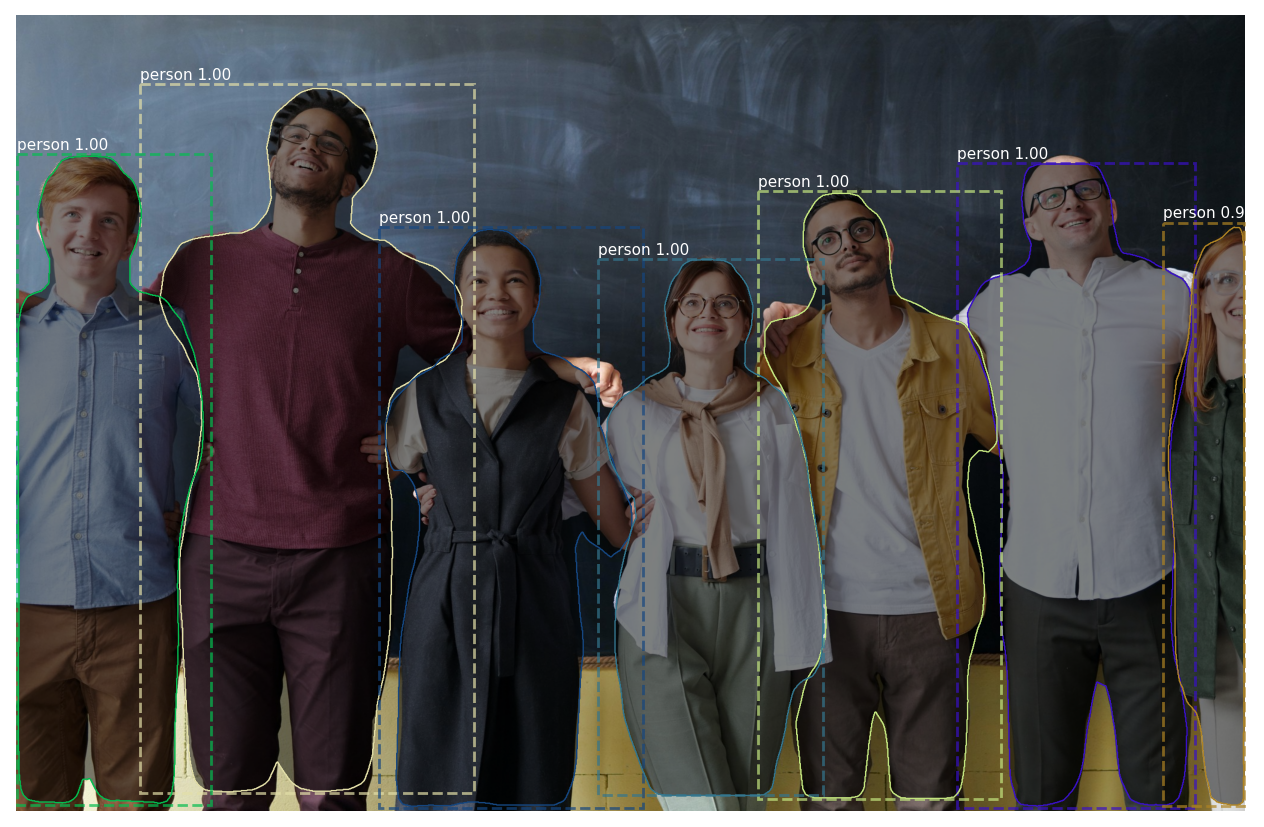


Detected objects:
person: 1.00
person: 1.00
person: 1.00
person: 1.00
person: 1.00
person: 1.00
person: 0.99


In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import random
import cv2
import os

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# COCO class names (91 classes including background)
COCO_CLASS_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def random_colors(N):
    """Generate random colors for visualization"""
    # Generate colors in the range 0-1 instead of 0-255
    colors = [tuple([random.random() for _ in range(3)]) for _ in range(N)]
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image with transparency"""
    for c in range(3):
        image[:, :, c] = np.where(
            mask == 1,
            image[:, :, c] * (1 - alpha) + alpha * color[c],
            image[:, :, c]
        )
    return image

def display_instances(image, boxes, masks, class_ids, class_names, scores=None,
                     title="", figsize=(16, 16), ax=None, show_mask=True, show_bbox=True):
   
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[0] == class_ids.shape[0]

    # If no axis is passed, create one
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if show_bbox:
            if not np.any(boxes[i]):
                continue
            x1, y1, x2, y2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if scores is not None:
            label = "{} {:.2f}".format(class_names[class_ids[i]], scores[i])
        else:
            label = class_names[class_ids[i]]

        ax.text(x1, y1 - 8, label, color='w', size=11, backgroundcolor="none")

        # Mask
        if show_mask:
            mask = masks[i]
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = cv2.findContours(padded_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        for contour in contours:
            verts = contour.reshape(-1, 2)
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)

    ax.imshow(masked_image.astype(np.uint8))
    plt.show()

def load_image(image_path):
    """Load and preprocess an image"""
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)
    # Convert to tensor and normalize
    image_tensor = F.to_tensor(image).to(device)
    return image, image_tensor

def detect_and_segment(model, image_path, score_threshold=0.7):
    """Run object detection and segmentation on an image"""
    # Load image
    image, image_tensor = load_image(image_path)

    # Put model in evaluation mode
    model.eval()

    # Run inference
    with torch.no_grad():
        predictions = model([image_tensor])

    # Filter predictions by score threshold
    masks = predictions[0]['masks'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    keep = scores >= score_threshold
    masks = masks[keep]
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    # Convert masks to binary format
    masks = masks.squeeze(1) > 0.5

    # Visualize results
    display_instances(image, boxes, masks, labels, COCO_CLASS_NAMES, scores)

    return {
        'boxes': boxes,
        'masks': masks,
        'class_ids': labels,
        'scores': scores
    }

def main():
    # Load pre-trained Mask R-CNN model from torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    model.to(device)

    # Example image path (replace with your image path)
    image_path = "/content/qyjFiZlFJPJtaZ0LHQcufIOdQ.png"  # or use sys.argv[1] to get from command line

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Run detection and segmentation
    results = detect_and_segment(model, image_path)

    # Print detected objects and their confidence scores
    print("\nDetected objects:")
    for i, class_id in enumerate(results['class_ids']):
        print(f"{COCO_CLASS_NAMES[class_id]}: {results['scores'][i]:.2f}")

if __name__ == "__main__":
    main()